In [60]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot as plt

In [61]:
# pulled from stackoverflow
def pd_read(filename, size=100000):
    # number of records in file (excludes header)
    n = sum(1 for line in open(filename)) - 1 
    
    # the 0-indexed header will not be included in the skip list
    skip = sorted(random.sample(range(1,n + 1), n - size))
    
    return pd.read_csv(filename, skiprows=skip)

In [62]:
# 
# train = pd.read_csv('~\\data\\expedia\\sample.csv') ## doesn't include header, used bash shuf
train = pd_read(r'C:\cygwin64\home\salis\data\expedia\train.csv',50000)

In [63]:
dests = pd.read_csv('~\\data\\expedia\\destinations.csv')
#test = pd.read_csv('~\\data\\expedia\\test.csv')

In [64]:
# the whole test data will fit, but I believe our models need a <= sized data set?
test = pd_read(r'C:\cygwin64\home\salis\data\expedia\test.csv',50000)

In [65]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2013-04-09 18:06:34,13,1,46,171,46087,3906.9076,4539,0,1,...,0,1,8267,1,1,1,2,50,675,19
1,2014-07-02 14:00:10,11,3,205,354,25315,97.0150,6450,0,0,...,0,1,24648,6,0,2,2,50,572,51
2,2014-07-16 13:53:49,2,3,66,184,20752,4906.1975,15775,0,0,...,0,1,8252,1,0,2,6,170,313,22
3,2013-02-03 14:38:32,2,3,66,363,46852,NaN,23532,1,0,...,0,1,1121,3,1,1,2,50,1054,47
4,2014-03-13 12:57:26,2,3,69,724,221,NaN,30850,1,0,...,0,1,44035,6,1,1,6,204,27,91


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  50000 non-null  object 
 1   site_name                  50000 non-null  int64  
 2   posa_continent             50000 non-null  int64  
 3   user_location_country      50000 non-null  int64  
 4   user_location_region       50000 non-null  int64  
 5   user_location_city         50000 non-null  int64  
 6   orig_destination_distance  32247 non-null  float64
 7   user_id                    50000 non-null  int64  
 8   is_mobile                  50000 non-null  int64  
 9   is_package                 50000 non-null  int64  
 10  channel                    50000 non-null  int64  
 11  srch_ci                    49951 non-null  object 
 12  srch_co                    49951 non-null  object 
 13  srch_adults_cnt            50000 non-null  int

In [67]:
train['srch_ci'] = pd.to_datetime(train['srch_ci'])
train['srch_co'] = pd.to_datetime(train['srch_co'])

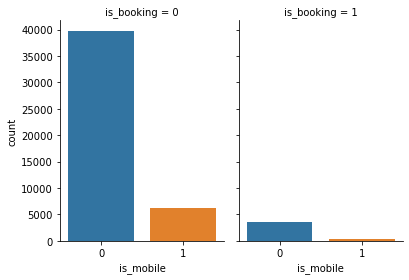

In [68]:
# see if bookings are done on mobile
g = sns.catplot(x="is_mobile", col="is_booking",
               data=train, kind="count",
               height=4, aspect=.7)

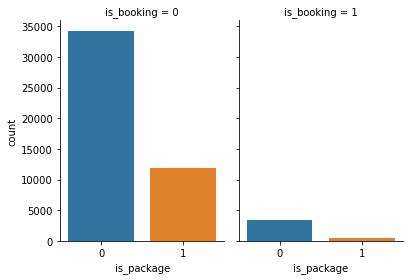

In [69]:
# see if bookings are done with a package
g = sns.catplot(x="is_package", col="is_booking",
               data=train, kind="count",
               height=4, aspect=.7)

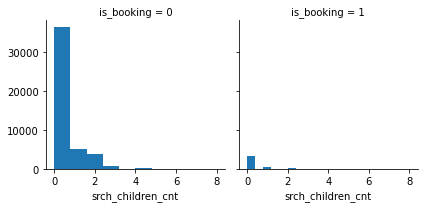

In [70]:
g = sns.FacetGrid(train,col="is_booking")
g.map(plt.hist,"srch_children_cnt")

c:\program files\python37\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


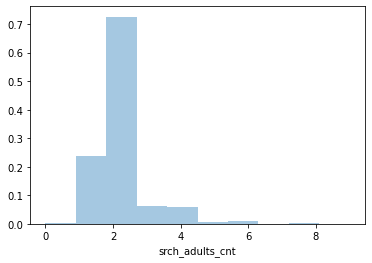

In [71]:
sns.distplot(train['srch_adults_cnt'], bins=10)

In [72]:
train['trip_m'] = pd.DatetimeIndex(train['srch_ci']).month

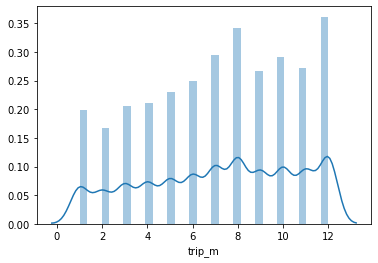

In [73]:
sns.distplot(train['trip_m'])

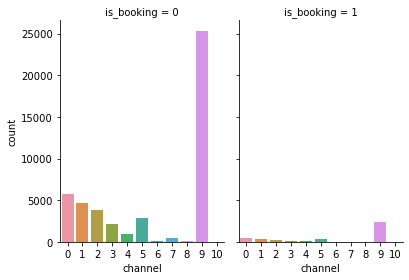

In [74]:
g = sns.catplot(x="channel", col="is_booking",
               data=train, kind="count",
               height=4, aspect=.7)

In [75]:
dests.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [76]:
train['trip_m'].fillna(method='ffill',inplace=True)

In [77]:
# zip up features going to use in model
features=list(zip(train['trip_m'],train['srch_children_cnt'], train['srch_destination_id'],train['is_booking']))

In [78]:
target=train['hotel_cluster']

In [79]:
model = KNeighborsClassifier(n_neighbors=5)

In [80]:
model.fit(features,target)

KNeighborsClassifier()

In [81]:
# test data set doesn't have is_booking, but all in test are successful bookings according to documentation
test['is_booking'] = 1

In [82]:
# There is a gnarly date out there, remove it
test = test[test['srch_ci'] < '2025']

In [83]:
test['srch_ci'] = pd.to_datetime(test['srch_ci'])
test['srch_co'] = pd.to_datetime(test['srch_co'])

In [84]:
test['trip_m'] = pd.DatetimeIndex(test['srch_ci']).month

In [85]:
fp=list(zip(test['trip_m'],test['srch_children_cnt'], test['srch_destination_id'],test['is_booking']))

In [86]:
predicted = model.predict(fp)

In [90]:
len(predicted)

50000

In [88]:
#drop_indices = np.random.choice(target.index, 2, replace=False)
#target_subset = target.drop(drop_indices)

In [91]:
print("Accuracy:",metrics.accuracy_score(target, predicted))

Accuracy: 0.01242


In [92]:
### I'm clearly on the wrong track here

In [93]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [94]:
nbClassifier = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [95]:
nb_model = Pipeline([('classifier', nbClassifier)])

In [96]:
nb_model.fit(features,target)

Pipeline(steps=[('classifier', MultinomialNB())])

In [97]:
nb_predict = nb_model.predict(fp)

In [99]:
print("Accuracy:",metrics.accuracy_score(target, nb_predict))

Accuracy: 0.01814


In [100]:
#### PCA in python

In [101]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [102]:
dests.columns

Index(['srch_destination_id', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8',
       'd9',
       ...
       'd140', 'd141', 'd142', 'd143', 'd144', 'd145', 'd146', 'd147', 'd148',
       'd149'],
      dtype='object', length=150)

In [103]:
train.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'trip_m'],
      dtype='object')

In [147]:
train_dest = train.merge(dests, on='srch_destination_id')

In [148]:
train_x = train_dest.copy(deep=True)

In [149]:
train_x.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       ...
       'd140', 'd141', 'd142', 'd143', 'd144', 'd145', 'd146', 'd147', 'd148',
       'd149'],
      dtype='object', length=174)

In [150]:
train_x.drop(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'srch_ci', 'srch_co',
       'channel','hotel_cluster'], axis=1, inplace=True)

In [151]:
train_y = train_dest['hotel_cluster']

In [105]:
pca = make_pipeline(StandardScaler(),
                    PCA(n_components=2, random_state=0))

In [106]:
lda = make_pipeline(StandardScaler(),
                    LinearDiscriminantAnalysis(n_components=2))

In [107]:
nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components=2,
                                                   random_state=0))

In [108]:
knn = KNeighborsClassifier(n_neighbors=2)

In [109]:
dim_reduction_methods = [('PCA', pca), ('LDA', lda), ('NCA', nca)]

In [110]:
# zip up features going to use in model
f=list(zip(train_dest['srch_adults_cnt'],train_dest['srch_children_cnt'], 
                  train_dest['srch_rm_cnt'],train_dest['srch_destination_id'],
                 train_dest['srch_destination_type_id'],train_dest['d1'],train_dest['d2'],train_dest['d3']))

In [111]:
t=train_dest['hotel_cluster']

In [143]:
#nca.fit(f,t)

In [144]:
from sklearn.model_selection import train_test_split

In [152]:
pca = PCA(n_components=10, whiten='True')

In [153]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.60, random_state=42)

In [154]:
x = pca.fit(X_train,y_train)

In [156]:
from sklearn.linear_model import LinearRegression

In [158]:
reg = LinearRegression()

In [159]:
reg.fit(X_test,y_test)

LinearRegression()

In [161]:
reg.score(X_test,y_test)

0.035260311020416046